# Segment Anything Model (SAM)

In [2]:
import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt
import torch
import cv2

In [3]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ndv47_0z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ndv47_0z
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36621 sha256=63162c7bc588b231dc34e9f4af126e040407083c3f925c188d8c123e7800d052
  Stored in directory: /tmp/pip-ephem-wheel-cache-csnu4hzj/wheels/6e/b2/38/082465c177a067501384fd15cb18be1128372ef60f27a1c426
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.


In [4]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


# Extracting the masks(ground truth) from hovenet image

resized image: (256, 256)


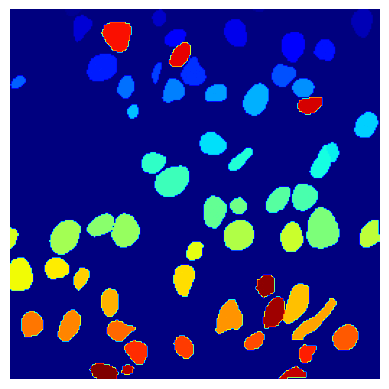

In [5]:

# Define the file path to save the image
output_file = '/kaggle/working/ground_truth_image1.png'
npy_file = '/kaggle/input/images-hover/2427.npy'


def display_masks_from_npy(npy_file):
    # Load the numpy array
    data = np.load(npy_file)
    
    # Extract the mask channel
    masks_hovernet = data[:, :, 3]  # Assuming the mask channel is at index 3
    
    resized_image = cv2.resize(masks_hovernet, (256, 256))
    print("resized image:",resized_image.shape)

    # Display the masks
    plt.imshow(resized_image, cmap='jet')  # Adjust the colormap as needed
    plt.axis('off')
    plt.savefig(output_file)  # Save the displayed image
    plt.show()
    
    return masks_hovernet


# Call the function to display the masks and save the image
masks_hovernet = display_masks_from_npy(npy_file)


# Generating Object Masks with SAM

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)

In [7]:
 if not os.path.isdir('/kaggle/working/imgs'):
    os.mkdir('/kaggle/working/imgs/')
    os.mkdir('/kaggle/working/imgs1/')

In [8]:
!cp -r /kaggle/input/images-hover/*.* /kaggle/working/imgs/

In [9]:
#Converting the numpyarray files to .png hovernet needs input as .png files
# Path to the folder containing the npy files
folder_path = '/kaggle/working/imgs/'

# Output folder for saving PNG images
output_folder = '/kaggle/working/imgs1/'

# List all files in the folder
file_list = os.listdir(folder_path)

# Loop through each file
for file_name in file_list:
    # Check if the file is an npy file
    if file_name.endswith('.npy'):
        # Construct the full path to the npy file
        file_path = os.path.join(folder_path, file_name)
        print (file_path)

        # Load the image from the npy file
        image = np.load(file_path)

        # Ensure the image is in the correct data type for saving as an image
        image = image.astype(np.uint8)

        # Extract the first three channels (assuming RGB format)
        rgb_image = image[:, :, :3] 
        img_gray = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

        # Save the image as a PNG file in the output folder
        output_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + '.png')
        cv2.imwrite(output_path, rgb_image)

/kaggle/working/imgs/2206.npy
/kaggle/working/imgs/2427.npy
/kaggle/working/imgs/2207.npy
/kaggle/working/imgs/2439.npy
/kaggle/working/imgs/2140.npy
/kaggle/working/imgs/2370.npy


**#Calculating the IUC and the dice score for images**

In [10]:
def calculate_metrics(masks):
    def calculate_overall_iou(iou_scores):
        overall_iou = sum(iou_scores) / len(iou_scores)
        return overall_iou

    def calculate_dice_from_iou(iou):
        dice = (2 * iou) / (1 + iou)
        return dice

    # Assuming masks is a list of dictionaries
    iou_scores = [mask['predicted_iou'] for mask in masks]

    overall_iou = calculate_overall_iou(iou_scores)
    dice_score = calculate_dice_from_iou(overall_iou)

    return overall_iou, dice_score


# #hovernet overlay images fed to SAM prompt

Number of channels in the input image: 3


Text(0.5, 1.0, 'SAM-Hovernet-Segmentation')

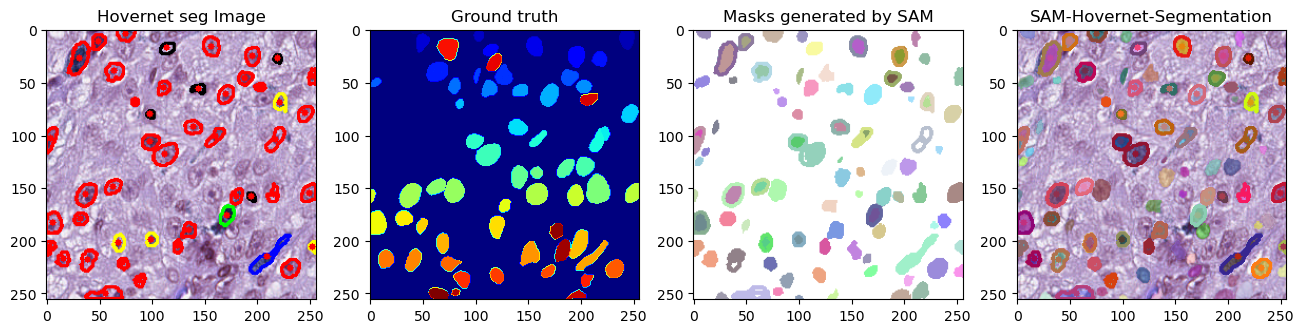

In [33]:
image_path = '/kaggle/input/hovernet-overlay/2427.png'


image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Print the number of channels in the input image
print(f"Number of channels in the input image: {image_array.shape[2]}")

#Generating the masks from predefined SAM model
masks = mask_generator.generate(image_array)

_, axes = plt.subplots(1,4, figsize=(16,16))
axes[0].imshow(image_array)
axes[0].set_title("Hovernet seg Image")
axes[1].imshow(masks_hovernet, cmap='jet')
axes[1].set_title("Ground truth")
show_anns(masks, axes[2])
axes[2].set_title("Masks generated by SAM")
axes[3].imshow(image_array)
show_anns(masks, axes[3])
axes[3].set_title("SAM-Hovernet-Segmentation")

# Specified predictions using points and boundary box

In [12]:
from segment_anything import sam_model_registry, SamPredictor

predictor = SamPredictor(sam)

Size of the Input image: (256, 256, 3)
Plotted and annotated image saved to: /kaggle/working/SAM-images/2427.png
Size of the Output image from SAM: (197, 197, 4)
Size of the resized image: (256, 256, 3)


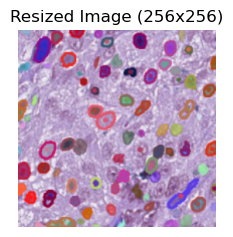

Applying BB cordinates of HOVERNET to SAM O/P Image


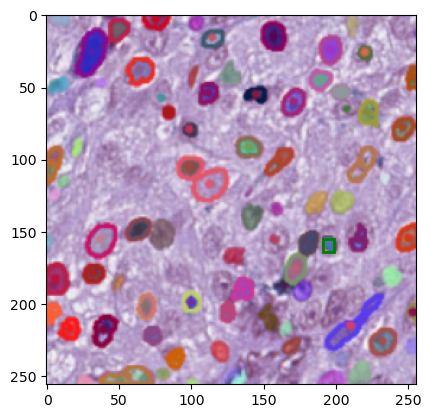

In [13]:
# Specify the output folder
output_folder = '/kaggle/working/SAM-images'

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Define the image path
image_path = '/kaggle/input/hovernet-overlay/2427.png'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
print(f"Size of the Input image: {image_array.shape}")
masks = mask_generator.generate(image_array)

# Set the figure size to match the input image dimensions in inches
fig_width, fig_height = image_array.shape[1] / 100, image_array.shape[0] / 100
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=100)

# Plot the image with annotations
ax.imshow(image_array)
show_anns(masks, ax)
ax.axis('off')

# Save the figure with the same name as the input file
output_path = os.path.join(output_folder, os.path.basename(image_path))
fig.savefig(output_path, format='png', bbox_inches='tight', pad_inches=0)

# Optionally, display the saved image path
print(f"Plotted and annotated image saved to: {output_path}")

# Read the saved image, strip the alpha channel, and resize to 256x256
saved_image = plt.imread(output_path)
print(f"Size of the Output image from SAM: {saved_image.shape}")
resized_image = cv2.resize(saved_image[:, :, :3], (256, 256))

# Print the size of the resized image
print(f"Size of the resized image: {resized_image.shape}")

# Display the resized image
plt.imshow(resized_image)
plt.title('Resized Image (256x256)')
plt.show()

# Convert resized_image to uint8
resized_image_uint8 = (resized_image * 255).astype(np.uint8)

# Set the image for prediction
predictor.set_image(resized_image_uint8)

#Applying the boundary box 
print(f"Applying BB cordinates of HOVERNET to SAM O/P Image")
input_box = np.array([191, 155, 199, 164])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.imshow(resized_image_uint8)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.show()

 Calculating the number of contours from the SAM segmented image

In [24]:
# Define the image path
image_path = '/kaggle/input/hovernet-overlay/2427.png'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image_array)
sam_points = []  # Initialize the list to store all point coordinates

# Extract 'point_coords' from the list of masks
point_coords = [mask['point_coords'] for mask in masks]

# Flatten the list of lists to get a single list of point coordinates
sam_points = [coord for sublist in point_coords for coord in sublist]

# Display the updated sam_points
print("SAM segmented region points len:", len(sam_points))

# Assuming masks is a list
#for i, mask_entry in enumerate(masks):
   # print(f"Entry {i + 1}:")
   # print(mask_entry)
   # print("\n") 108

SAM segmented region points len: 108


Extracted contour points from hovernet 

In [25]:
points = []
contour_points = [[67, 0], [67, 5], [69, 7], [69, 8], [71, 10], [75, 10], [76, 11], [79, 11], [79, 10], [80, 9], [81, 9], [81, 8], [83, 6], [83, 4], [84, 3], [84, 0]]

# Add the contour points to the points list
points.extend(contour_points)

# Display the updated points list
print("Updated points list for hovernet segmentation:", len(points))


Updated points list for hovernet segments: 16


Extracting the points for the ground truth image

In [27]:
# Define the image path
image_path = '/kaggle/working/ground_truth_image1.png'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image_array)

# Assuming masks is a list
#for i, mask_entry in enumerate(masks):
   # print(f"Entry {i + 1}:")
    #print(mask_entry)
   # print("\n") 

ground_truth_points = []  # Initialize the list to store all point coordinates

# Extract 'point_coords' from the list of masks
point_coords = [mask['point_coords'] for mask in masks]

# Flatten the list of lists to get a single list of point coordinates
ground_truth_points = [coord for sublist in point_coords for coord in sublist]

# Display the updated sam_points
print("Ground truth contour points len:", len(ground_truth_points))


Ground truth points len: 74


# **#Calculating IOU/Dice score for segmented images of hovernet applied to SAM prompt**

In [15]:
def calculate_overall_iou(iou_scores):
    overall_iou = sum(iou_scores) / len(iou_scores)
    return overall_iou

def calculate_dice_from_iou(iou):
    dice = (2 * iou) / (1 + iou)
    return dice

# Specify the directory path
directory_path = '/kaggle/input/hovernet-overlay-02/images'

# Initialize lists to store overall metrics for all images
overall_iou_list = []
dice_score_list = []

# Iterate over all files in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith('.png'):
        image_path = os.path.join(directory_path, file_name)

        # Read and process the image
        image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        masks = mask_generator.generate(image_array)

        # Calculate metrics
        iou_scores = [mask['predicted_iou'] for mask in masks]
        overall_iou = calculate_overall_iou(iou_scores)
        dice_score = calculate_dice_from_iou(overall_iou)

        # Append metrics to lists
        overall_iou_list.append(overall_iou)
        dice_score_list.append(dice_score)

        #print(f"Image: {file_name}")
        #print(f"Overall IoU: {overall_iou}")
        #print(f"Overall Dice score: {dice_score}")
        #print("\n")

# Calculate and print overall metrics for all images
overall_iou_avg = sum(overall_iou_list) / len(overall_iou_list)
overall_dice_avg = sum(dice_score_list) / len(dice_score_list)
print(f"Overall Average IoU for all images: {overall_iou_avg}")
print(f"Overall Average Dice score for all images: {overall_dice_avg}")


KeyboardInterrupt: 

In [ ]:
del(mask_generator)

# Calculating the Hausdorff distance for hover net and SAM images

In [29]:
!pip install hausdorff

  Preparing metadata (setup.py) ... done
  Created wheel for hausdorff: filename=hausdorff-0.2.6-py3-none-any.whl size=15217 sha256=4322c374cfb3aa46e646fc4e9fae696ed7f32ae40f8a69fe462a32bfe9c4f2a7
  Stored in directory: /root/.cache/pip/wheels/14/d0/79/3d9eec1d9ea9eb00b69dd6cd0a80436fded9c9f021ee6db327
Successfully built hausdorff


In [32]:
from hausdorff import hausdorff_distance

def calculate_hausdorff_distance(points_segmented1, points_segmented2):
    
     # Convert points to numpy arrays
    points_segmented = np.array(points_segmented2)
    points_ground_truth = np.array(points_segmented1)

    # Calculate Hausdorff distance between the sets of points
    distance = hausdorff_distance(points_ground_truth, points_segmented)
    return distance


distance = calculate_hausdorff_distance(ground_truth_points, points)
sam_distance = calculate_hausdorff_distance(ground_truth_points, sam_points)
print("Hausdorff distance between hovernet segmentation and groundtruth:", distance)
print("Hausdorff distance between groundtruth and SAM-hovernet segmentation:", sam_distance)

Hausdorff distance between hovernet segmentation and groundtruth: 544.677197980602
Hausdorff distance between groundtruth and SAM-hovernet segmentation: 267.36538669019967


 Object masks from prompts with SAM
 
https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
https://stackoverflow.com/questions/19028830/convert-4-channel-image-to-3-channel-image

additional prompting options:

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
https://github.com/facebookresearch/segment-anything#model-checkpoints

https://arxiv.org/pdf/2305.11513.pdf